In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

In [1]:
%run 'functions.py'

In [3]:
total_acorn = pd.read_parquet('../data/total_acorn.gzip')

affluent = total_acorn.loc[total_acorn['acorn_category'] == 'Affluent']['house_id']
comfortable = total_acorn.loc[total_acorn['acorn_category'] == 'Comfortable']['house_id']
adversity = total_acorn.loc[total_acorn['acorn_category'] == 'Adversity']['house_id']

In [4]:
tariffs = pd.read_parquet('../data/tariffs.gzip')

lows = np.array(tariffs.index[tariffs['tariff'] == 'Low'], dtype=np.datetime64)
normals = np.array(tariffs.index[tariffs['tariff'] == 'Normal'], dtype=np.datetime64)
highs = np.array(tariffs.index[tariffs['tariff'] == 'High'], dtype=np.datetime64)

lows_2012 = lows - np.timedelta64(365, 'D')
normals_2012 = normals - np.timedelta64(365, 'D')
highs_2012 = highs - np.timedelta64(365, 'D')

In [6]:
total_usage_2012 = pd.read_parquet('../data/total_usage_2012.gzip')
total_usage_2013 = pd.read_parquet('../data/total_usage_2013.gzip')

In [9]:
# include a p/kWh & c/hh column that includes the price for that hh
total_usage_2012['p/kWh'] = 14.228
total_usage_2012['c/hh'] = total_usage_2012['KWH/hh'] * total_usage_2012['p/kWh']

total_usage_2013.loc[total_usage_2013['treated'], 'p/kWh'] = tariffs.loc[total_usage_2013.loc[total_usage_2013['treated'], 'date_time'], 'p/kWh'].values
total_usage_2013.loc[~total_usage_2013['treated'], 'p/kWh'] = 14.228
total_usage_2013['c/hh'] = total_usage_2013['KWH/hh'] * total_usage_2013['p/kWh']

In [11]:
total_usage_2012_affluent = total_usage_2012[total_usage_2012['house_id'].isin(affluent)]
total_usage_2013_affluent = total_usage_2013[total_usage_2013['house_id'].isin(affluent)]

total_usage_2012_comfortable = total_usage_2012[total_usage_2012['house_id'].isin(comfortable)]
total_usage_2013_comfortable = total_usage_2013[total_usage_2013['house_id'].isin(comfortable)]

total_usage_2012_adversity = total_usage_2012[total_usage_2012['house_id'].isin(adversity)]
total_usage_2013_adversity = total_usage_2013[total_usage_2013['house_id'].isin(adversity)]

In [12]:
# INVESTIGATE THIS
print(total_usage_2012_comfortable['house_id'].nunique())
print(total_usage_2013_comfortable['house_id'].nunique())

1504
1494


In [41]:
mean_over_houses_per_hh_2012 = mean_over_houses_per_hh(total_usage_2012)
mean_over_houses_per_hh_2013 = mean_over_houses_per_hh(total_usage_2013)

mean_over_houses_per_hh_2012_affluent = mean_over_houses_per_hh(total_usage_2012_affluent)
mean_over_houses_per_hh_2013_affluent = mean_over_houses_per_hh(total_usage_2013_affluent)

mean_over_houses_per_hh_2012_comfortable = mean_over_houses_per_hh(total_usage_2012_comfortable)
mean_over_houses_per_hh_2013_comfortable = mean_over_houses_per_hh(total_usage_2013_comfortable)

mean_over_houses_per_hh_2012_adversity = mean_over_houses_per_hh(total_usage_2012_adversity)
mean_over_houses_per_hh_2013_adversity = mean_over_houses_per_hh(total_usage_2013_adversity)

In [42]:
# Error Analysis
# train on 0.7 and find the error on 0.3

# split your data into train and test
Y = mean_over_houses_per_hh_2013['KWH/hh', False].values.reshape(-1, 1)
X = mean_over_houses_per_hh_2012['KWH/hh', False].values.reshape(-1, 1)

train_size = int(0.7*len(X))
ytrain, xtrain = Y[:train_size], X[:train_size]
ytest, xtest = Y[train_size:], X[train_size:]

linear_regressor_error = LinearRegression()  # create object for the class
linear_regressor_error.fit(xtrain, ytrain)  # perform linear regression
ytest_pred = linear_regressor_error.predict(xtest)  # make predictions

print('mean error:', (ytest - ytest_pred).mean())
print('std error:', (ytest - ytest_pred).std())
print('mean percent error:', ((ytest - ytest_pred)/ytest*100).mean())

mean error: -0.00468470085024832
std error: 0.022431517161480004
mean percent error: -3.6128670081452983


In [ ]:
print('mean error:', ytest.mean() - ytest_pred.mean())
print('mean percent error:', (ytest.mean() - ytest_pred.mean())/ytest.mean()*100)

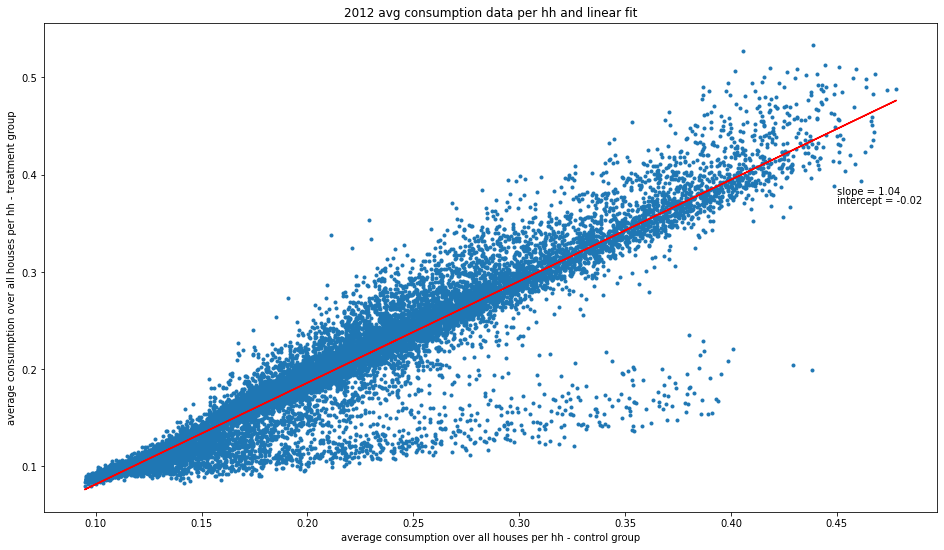

In [43]:
Y = mean_over_houses_per_hh_2012['KWH/hh', True].values.reshape(-1, 1)
X = mean_over_houses_per_hh_2012['KWH/hh', False].values.reshape(-1, 1)

linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred_2012 = linear_regressor.predict(X)

plt.figure(figsize=(16, 9))
plt.scatter(X, Y, marker='.')
plt.plot(X, Y_pred_2012, color='red')
plt.annotate('slope = '+str(round(linear_regressor.coef_[0][0], 2)), xy=(0.45, 0.38))
plt.annotate('intercept = '+str(round(linear_regressor.intercept_[0], 2)), xy=(0.45, 0.37))
plt.title("2012 avg consumption data per hh and linear fit")
plt.xlabel("average consumption over all houses per hh - control group")
plt.ylabel("average consumption over all houses per hh - treatment group")
plt.savefig('../figs/2012_avg.png')
plt.show()

In [44]:
# def find_linreg_control_treatment(df):
#     """
#     takes in df, splits into control and treatment data
#     regresses the treatment data (y) on the control data (x)
#     returns the predicted y values and the LinearRegression
#     object"""
#     Y = df['KWH/hh', True].values.reshape(-1, 1)
#     X = df['KWH/hh', False].values.reshape(-1, 1)

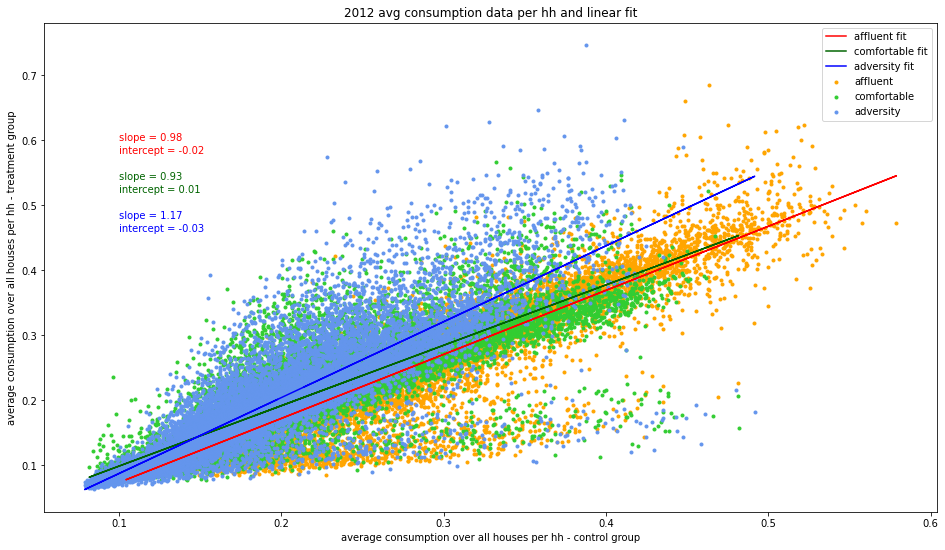

In [45]:
Y_affluent = mean_over_houses_per_hh_2012_affluent['KWH/hh', True].values.reshape(-1, 1)
X_affluent = mean_over_houses_per_hh_2012_affluent['KWH/hh', False].values.reshape(-1, 1)

linear_regressor_affluent = LinearRegression()
linear_regressor_affluent.fit(X_affluent, Y_affluent)
Y_pred_2012_affluent = linear_regressor_affluent.predict(X_affluent)

Y_comfortable = mean_over_houses_per_hh_2012_comfortable['KWH/hh', True].values.reshape(-1, 1)
X_comfortable = mean_over_houses_per_hh_2012_comfortable['KWH/hh', False].values.reshape(-1, 1)

linear_regressor_comfortable = LinearRegression()
linear_regressor_comfortable.fit(X_comfortable, Y_comfortable)
Y_pred_2012_comfortable = linear_regressor_comfortable.predict(X_comfortable)

Y_adversity = mean_over_houses_per_hh_2012_adversity['KWH/hh', True].values.reshape(-1, 1)
X_adversity = mean_over_houses_per_hh_2012_adversity['KWH/hh', False].values.reshape(-1, 1)

linear_regressor_adversity = LinearRegression()
linear_regressor_adversity.fit(X_adversity, Y_adversity)
Y_pred_2012_adversity = linear_regressor_adversity.predict(X_adversity)

plt.figure(figsize=(16, 9))
plt.title("2012 avg consumption data per hh and linear fit")
plt.xlabel("average consumption over all houses per hh - control group")
plt.ylabel("average consumption over all houses per hh - treatment group")

plt.scatter(X_affluent, Y_affluent, label='affluent', marker='.', color='orange')
plt.plot(X_affluent, Y_pred_2012_affluent, label='affluent fit', color='red')
plt.annotate('slope = '+str(round(linear_regressor_affluent.coef_[0][0], 2)), xy=(0.1, 0.6), color='red')
plt.annotate('intercept = '+str(round(linear_regressor_affluent.intercept_[0], 2)), xy=(0.1, 0.58), color='red')

plt.scatter(X_comfortable, Y_comfortable, label='comfortable', marker='.', color='limegreen')
plt.plot(X_comfortable, Y_pred_2012_comfortable, label='comfortable fit', color='darkgreen')
plt.annotate('slope = '+str(round(linear_regressor_comfortable.coef_[0][0], 2)), xy=(0.1, 0.54), color='darkgreen')
plt.annotate('intercept = '+str(round(linear_regressor_comfortable.intercept_[0], 2)), xy=(0.1, 0.52), color='darkgreen')

plt.scatter(X_adversity, Y_adversity, label='adversity', marker='.', color='cornflowerblue')
plt.plot(X_adversity, Y_pred_2012_adversity, label='adversity fit', color='blue')
plt.annotate('slope = '+str(round(linear_regressor_adversity.coef_[0][0], 2)), xy=(0.1, 0.48), color='blue')
plt.annotate('intercept = '+str(round(linear_regressor_adversity.intercept_[0], 2)), xy=(0.1, 0.46), color='blue')

plt.legend(loc=1)
plt.savefig('../figs/2012_avg_socio_breakdown.png')
plt.show()

In [46]:
# def fill_c_consumption(df, linreg):
    
mean_over_houses_per_hh_2013['c_KWH/hh', True] = linear_regressor.predict(mean_over_houses_per_hh_2013['KWH/hh', False].values.reshape(-1, 1))
mean_over_houses_per_hh_2013_affluent['c_KWH/hh', True] = linear_regressor.predict(mean_over_houses_per_hh_2013_affluent['KWH/hh', False].values.reshape(-1, 1))
mean_over_houses_per_hh_2013_comfortable['c_KWH/hh', True] = linear_regressor.predict(mean_over_houses_per_hh_2013_comfortable['KWH/hh', False].values.reshape(-1, 1))
mean_over_houses_per_hh_2013_adversity['c_KWH/hh', True] = linear_regressor.predict(mean_over_houses_per_hh_2013_adversity['KWH/hh', False].values.reshape(-1, 1))

mean_over_houses_per_hh_2013_affluent['c2_KWH/hh', True] = linear_regressor_affluent.predict(mean_over_houses_per_hh_2013_affluent['KWH/hh', False].values.reshape(-1, 1))
mean_over_houses_per_hh_2013_comfortable['c2_KWH/hh', True] = linear_regressor_comfortable.predict(mean_over_houses_per_hh_2013_comfortable['KWH/hh', False].values.reshape(-1, 1))
mean_over_houses_per_hh_2013_adversity['c2_KWH/hh', True] = linear_regressor_adversity.predict(mean_over_houses_per_hh_2013_adversity['KWH/hh', False].values.reshape(-1, 1))

In [47]:
mean_over_houses_per_hh_2013['c_c/hh', True] = mean_over_houses_per_hh_2013['c_KWH/hh', True]*14.228
mean_over_houses_per_hh_2013_affluent['c_c/hh', True] = mean_over_houses_per_hh_2013_affluent['c_KWH/hh', True]*14.228
mean_over_houses_per_hh_2013_comfortable['c_c/hh', True] = mean_over_houses_per_hh_2013_comfortable['c_KWH/hh', True]*14.228
mean_over_houses_per_hh_2013_adversity['c_c/hh', True] = mean_over_houses_per_hh_2013_adversity['c_KWH/hh', True]*14.228

mean_over_houses_per_hh_2013_affluent['c2_c/hh', True] = mean_over_houses_per_hh_2013_affluent['c2_KWH/hh', True]*14.228
mean_over_houses_per_hh_2013_comfortable['c2_c/hh', True] = mean_over_houses_per_hh_2013_comfortable['c2_KWH/hh', True]*14.228
mean_over_houses_per_hh_2013_adversity['c2_c/hh', True] = mean_over_houses_per_hh_2013_adversity['c2_KWH/hh', True]*14.228

In [48]:
ME_consumption = pd.DataFrame([], index=['Affluent', 'Comfortable', 'Adversity', 'Overall'], columns=['Low', 'Normal', 'High', 'Overall'])
MPE_consumption = pd.DataFrame([], index=['Affluent', 'Comfortable', 'Adversity', 'Overall'], columns=['Low', 'Normal', 'High', 'Overall'])
ME2_consumption = pd.DataFrame([], index=['Affluent', 'Comfortable', 'Adversity'], columns=['Low', 'Normal', 'High', 'Overall'])
MPE2_consumption = pd.DataFrame([], index=['Affluent', 'Comfortable', 'Adversity'], columns=['Low', 'Normal', 'High', 'Overall'])

ME_cost = pd.DataFrame([], index=['Affluent', 'Comfortable', 'Adversity', 'Overall'], columns=['Low', 'Normal', 'High', 'Overall'])
MPE_cost = pd.DataFrame([], index=['Affluent', 'Comfortable', 'Adversity', 'Overall'], columns=['Low', 'Normal', 'High', 'Overall'])
ME2_cost = pd.DataFrame([], index=['Affluent', 'Comfortable', 'Adversity'], columns=['Low', 'Normal', 'High', 'Overall'])
MPE2_cost = pd.DataFrame([], index=['Affluent', 'Comfortable', 'Adversity'], columns=['Low', 'Normal', 'High', 'Overall'])

In [49]:
ME_consumption.loc['Affluent', 'Low'], MPE_consumption.loc['Affluent', 'Low'] = return_me_mpe(
    mean_over_houses_per_hh_2013_affluent.iloc[mean_over_houses_per_hh_2013_affluent.index.isin(lows)], 'KWH/hh', 'c_KWH/hh')

ME_consumption.loc['Affluent', 'Normal'], MPE_consumption.loc['Affluent', 'Normal'] = return_me_mpe(
    mean_over_houses_per_hh_2013_affluent.iloc[mean_over_houses_per_hh_2013_affluent.index.isin(normals)], 'KWH/hh', 'c_KWH/hh')

ME_consumption.loc['Affluent', 'High'], MPE_consumption.loc['Affluent', 'High'] = return_me_mpe(
    mean_over_houses_per_hh_2013_affluent.iloc[mean_over_houses_per_hh_2013_affluent.index.isin(highs)], 'KWH/hh', 'c_KWH/hh')

ME_consumption.loc['Affluent', 'Overall'], MPE_consumption.loc['Affluent', 'Overall'] = return_me_mpe(
    mean_over_houses_per_hh_2013_affluent, 'KWH/hh', 'c_KWH/hh')


ME_consumption.loc['Comfortable', 'Low'], MPE_consumption.loc['Comfortable', 'Low'] = return_me_mpe(
    mean_over_houses_per_hh_2013_comfortable.iloc[mean_over_houses_per_hh_2013_comfortable.index.isin(lows)], 'KWH/hh', 'c_KWH/hh')

ME_consumption.loc['Comfortable', 'Normal'], MPE_consumption.loc['Comfortable', 'Normal'] = return_me_mpe(
    mean_over_houses_per_hh_2013_comfortable.iloc[mean_over_houses_per_hh_2013_comfortable.index.isin(normals)], 'KWH/hh', 'c_KWH/hh')

ME_consumption.loc['Comfortable', 'High'], MPE_consumption.loc['Comfortable', 'High'] = return_me_mpe(
    mean_over_houses_per_hh_2013_comfortable.iloc[mean_over_houses_per_hh_2013_comfortable.index.isin(highs)], 'KWH/hh', 'c_KWH/hh')

ME_consumption.loc['Comfortable', 'Overall'], MPE_consumption.loc['Comfortable', 'Overall'] = return_me_mpe(
    mean_over_houses_per_hh_2013_comfortable, 'KWH/hh', 'c_KWH/hh')


ME_consumption.loc['Adversity', 'Low'], MPE_consumption.loc['Adversity', 'Low'] = return_me_mpe(
    mean_over_houses_per_hh_2013_adversity.iloc[mean_over_houses_per_hh_2013_adversity.index.isin(lows)], 'KWH/hh', 'c_KWH/hh')

ME_consumption.loc['Adversity', 'Normal'], MPE_consumption.loc['Adversity', 'Normal'] = return_me_mpe(
    mean_over_houses_per_hh_2013_adversity.iloc[mean_over_houses_per_hh_2013_adversity.index.isin(normals)], 'KWH/hh', 'c_KWH/hh')

ME_consumption.loc['Adversity', 'High'], MPE_consumption.loc['Adversity', 'High'] = return_me_mpe(
    mean_over_houses_per_hh_2013_adversity.iloc[mean_over_houses_per_hh_2013_adversity.index.isin(highs)], 'KWH/hh', 'c_KWH/hh')

ME_consumption.loc['Adversity', 'Overall'], MPE_consumption.loc['Adversity', 'Overall'] = return_me_mpe(
    mean_over_houses_per_hh_2013_adversity, 'KWH/hh', 'c_KWH/hh')


ME_consumption.loc['Overall', 'Low'], MPE_consumption.loc['Overall', 'Low'] = return_me_mpe(
    mean_over_houses_per_hh_2013.iloc[mean_over_houses_per_hh_2013.index.isin(lows)], 'KWH/hh', 'c_KWH/hh')

ME_consumption.loc['Overall', 'Normal'], MPE_consumption.loc['Overall', 'Normal'] = return_me_mpe(
    mean_over_houses_per_hh_2013.iloc[mean_over_houses_per_hh_2013.index.isin(normals)], 'KWH/hh', 'c_KWH/hh')

ME_consumption.loc['Overall', 'High'], MPE_consumption.loc['Overall', 'High'] = return_me_mpe(
    mean_over_houses_per_hh_2013.iloc[mean_over_houses_per_hh_2013.index.isin(highs)], 'KWH/hh', 'c_KWH/hh')

ME_consumption.loc['Overall', 'Overall'], MPE_consumption.loc['Overall', 'Overall'] = return_me_mpe(
    mean_over_houses_per_hh_2013, 'KWH/hh', 'c_KWH/hh')

In [50]:
ME_cost.loc['Affluent', 'Low'], MPE_cost.loc['Affluent', 'Low'] = return_me_mpe(
    mean_over_houses_per_hh_2013_affluent.iloc[mean_over_houses_per_hh_2013_affluent.index.isin(lows)], 'c/hh', 'c_c/hh')

ME_cost.loc['Affluent', 'Normal'], MPE_cost.loc['Affluent', 'Normal'] = return_me_mpe(
    mean_over_houses_per_hh_2013_affluent.iloc[mean_over_houses_per_hh_2013_affluent.index.isin(normals)], 'c/hh', 'c_c/hh')

ME_cost.loc['Affluent', 'High'], MPE_cost.loc['Affluent', 'High'] = return_me_mpe(
    mean_over_houses_per_hh_2013_affluent.iloc[mean_over_houses_per_hh_2013_affluent.index.isin(highs)], 'c/hh', 'c_c/hh')

ME_cost.loc['Affluent', 'Overall'], MPE_cost.loc['Affluent', 'Overall'] = return_me_mpe(
    mean_over_houses_per_hh_2013_affluent, 'c/hh', 'c_c/hh')


ME_cost.loc['Comfortable', 'Low'], MPE_cost.loc['Comfortable', 'Low'] = return_me_mpe(
    mean_over_houses_per_hh_2013_comfortable.iloc[mean_over_houses_per_hh_2013_comfortable.index.isin(lows)], 'c/hh', 'c_c/hh')

ME_cost.loc['Comfortable', 'Normal'], MPE_cost.loc['Comfortable', 'Normal'] = return_me_mpe(
    mean_over_houses_per_hh_2013_comfortable.iloc[mean_over_houses_per_hh_2013_comfortable.index.isin(normals)], 'c/hh', 'c_c/hh')

ME_cost.loc['Comfortable', 'High'], MPE_cost.loc['Comfortable', 'High'] = return_me_mpe(
    mean_over_houses_per_hh_2013_comfortable.iloc[mean_over_houses_per_hh_2013_comfortable.index.isin(highs)], 'c/hh', 'c_c/hh')

ME_cost.loc['Comfortable', 'Overall'], MPE_cost.loc['Comfortable', 'Overall'] = return_me_mpe(
    mean_over_houses_per_hh_2013_comfortable, 'c/hh', 'c_c/hh')


ME_cost.loc['Adversity', 'Low'], MPE_cost.loc['Adversity', 'Low'] = return_me_mpe(
    mean_over_houses_per_hh_2013_adversity.iloc[mean_over_houses_per_hh_2013_adversity.index.isin(lows)], 'c/hh', 'c_c/hh')

ME_cost.loc['Adversity', 'Normal'], MPE_cost.loc['Adversity', 'Normal'] = return_me_mpe(
    mean_over_houses_per_hh_2013_adversity.iloc[mean_over_houses_per_hh_2013_adversity.index.isin(normals)], 'c/hh', 'c_c/hh')

ME_cost.loc['Adversity', 'High'], MPE_cost.loc['Adversity', 'High'] = return_me_mpe(
    mean_over_houses_per_hh_2013_adversity.iloc[mean_over_houses_per_hh_2013_adversity.index.isin(highs)], 'c/hh', 'c_c/hh')

ME_cost.loc['Adversity', 'Overall'], MPE_cost.loc['Adversity', 'Overall'] = return_me_mpe(
    mean_over_houses_per_hh_2013_adversity, 'c/hh', 'c_c/hh')


ME_cost.loc['Overall', 'Low'], MPE_cost.loc['Overall', 'Low'] = return_me_mpe(
    mean_over_houses_per_hh_2013.iloc[mean_over_houses_per_hh_2013.index.isin(lows)], 'c/hh', 'c_c/hh')

ME_cost.loc['Overall', 'Normal'], MPE_cost.loc['Overall', 'Normal'] = return_me_mpe(
    mean_over_houses_per_hh_2013.iloc[mean_over_houses_per_hh_2013.index.isin(normals)], 'c/hh', 'c_c/hh')

ME_cost.loc['Overall', 'High'], MPE_cost.loc['Overall', 'High'] = return_me_mpe(
    mean_over_houses_per_hh_2013.iloc[mean_over_houses_per_hh_2013.index.isin(highs)], 'c/hh', 'c_c/hh')

ME_cost.loc['Overall', 'Overall'], MPE_cost.loc['Overall', 'Overall'] = return_me_mpe(
    mean_over_houses_per_hh_2013, 'c/hh', 'c_c/hh')

In [51]:
ME2_consumption.loc['Affluent', 'Low'], MPE2_consumption.loc['Affluent', 'Low'] = return_me_mpe(
    mean_over_houses_per_hh_2013_affluent.iloc[mean_over_houses_per_hh_2013_affluent.index.isin(lows)], 'KWH/hh', 'c2_KWH/hh')

ME2_consumption.loc['Affluent', 'Normal'], MPE2_consumption.loc['Affluent', 'Normal'] = return_me_mpe(
    mean_over_houses_per_hh_2013_affluent.iloc[mean_over_houses_per_hh_2013_affluent.index.isin(normals)], 'KWH/hh', 'c2_KWH/hh')

ME2_consumption.loc['Affluent', 'High'], MPE2_consumption.loc['Affluent', 'High'] = return_me_mpe(
    mean_over_houses_per_hh_2013_affluent.iloc[mean_over_houses_per_hh_2013_affluent.index.isin(highs)], 'KWH/hh', 'c2_KWH/hh')

ME2_consumption.loc['Affluent', 'Overall'], MPE2_consumption.loc['Affluent', 'Overall'] = return_me_mpe(
    mean_over_houses_per_hh_2013_affluent, 'KWH/hh', 'c2_KWH/hh')


ME2_consumption.loc['Comfortable', 'Low'], MPE2_consumption.loc['Comfortable', 'Low'] = return_me_mpe(
    mean_over_houses_per_hh_2013_comfortable.iloc[mean_over_houses_per_hh_2013_comfortable.index.isin(lows)], 'KWH/hh', 'c2_KWH/hh')

ME2_consumption.loc['Comfortable', 'Normal'], MPE2_consumption.loc['Comfortable', 'Normal'] = return_me_mpe(
    mean_over_houses_per_hh_2013_comfortable.iloc[mean_over_houses_per_hh_2013_comfortable.index.isin(normals)], 'KWH/hh', 'c2_KWH/hh')

ME2_consumption.loc['Comfortable', 'High'], MPE2_consumption.loc['Comfortable', 'High'] = return_me_mpe(
    mean_over_houses_per_hh_2013_comfortable.iloc[mean_over_houses_per_hh_2013_comfortable.index.isin(highs)], 'KWH/hh', 'c2_KWH/hh')

ME2_consumption.loc['Comfortable', 'Overall'], MPE2_consumption.loc['Comfortable', 'Overall'] = return_me_mpe(
    mean_over_houses_per_hh_2013_comfortable, 'KWH/hh', 'c2_KWH/hh')


ME2_consumption.loc['Adversity', 'Low'], MPE2_consumption.loc['Adversity', 'Low'] = return_me_mpe(
    mean_over_houses_per_hh_2013_adversity.iloc[mean_over_houses_per_hh_2013_adversity.index.isin(lows)], 'KWH/hh', 'c2_KWH/hh')

ME2_consumption.loc['Adversity', 'Normal'], MPE2_consumption.loc['Adversity', 'Normal'] = return_me_mpe(
    mean_over_houses_per_hh_2013_adversity.iloc[mean_over_houses_per_hh_2013_adversity.index.isin(normals)], 'KWH/hh', 'c2_KWH/hh')

ME2_consumption.loc['Adversity', 'High'], MPE2_consumption.loc['Adversity', 'High'] = return_me_mpe(
    mean_over_houses_per_hh_2013_adversity.iloc[mean_over_houses_per_hh_2013_adversity.index.isin(highs)], 'KWH/hh', 'c2_KWH/hh')

ME2_consumption.loc['Adversity', 'Overall'], MPE2_consumption.loc['Adversity', 'Overall'] = return_me_mpe(
    mean_over_houses_per_hh_2013_adversity, 'KWH/hh', 'c2_KWH/hh')

In [52]:
ME2_cost.loc['Affluent', 'Low'], MPE2_cost.loc['Affluent', 'Low'] = return_me_mpe(
    mean_over_houses_per_hh_2013_affluent.iloc[mean_over_houses_per_hh_2013_affluent.index.isin(lows)], 'c/hh', 'c2_c/hh')

ME2_cost.loc['Affluent', 'Normal'], MPE2_cost.loc['Affluent', 'Normal'] = return_me_mpe(
    mean_over_houses_per_hh_2013_affluent.iloc[mean_over_houses_per_hh_2013_affluent.index.isin(normals)], 'c/hh', 'c2_c/hh')

ME2_cost.loc['Affluent', 'High'], MPE2_cost.loc['Affluent', 'High'] = return_me_mpe(
    mean_over_houses_per_hh_2013_affluent.iloc[mean_over_houses_per_hh_2013_affluent.index.isin(highs)], 'c/hh', 'c2_c/hh')

ME2_cost.loc['Affluent', 'Overall'], MPE2_cost.loc['Affluent', 'Overall'] = return_me_mpe(
    mean_over_houses_per_hh_2013_affluent, 'c/hh', 'c2_c/hh')


ME2_cost.loc['Comfortable', 'Low'], MPE2_cost.loc['Comfortable', 'Low'] = return_me_mpe(
    mean_over_houses_per_hh_2013_comfortable.iloc[mean_over_houses_per_hh_2013_comfortable.index.isin(lows)], 'c/hh', 'c2_c/hh')

ME2_cost.loc['Comfortable', 'Normal'], MPE2_cost.loc['Comfortable', 'Normal'] = return_me_mpe(
    mean_over_houses_per_hh_2013_comfortable.iloc[mean_over_houses_per_hh_2013_comfortable.index.isin(normals)], 'c/hh', 'c2_c/hh')

ME2_cost.loc['Comfortable', 'High'], MPE2_cost.loc['Comfortable', 'High'] = return_me_mpe(
    mean_over_houses_per_hh_2013_comfortable.iloc[mean_over_houses_per_hh_2013_comfortable.index.isin(highs)], 'c/hh', 'c2_c/hh')

ME2_cost.loc['Comfortable', 'Overall'], MPE2_cost.loc['Comfortable', 'Overall'] = return_me_mpe(
    mean_over_houses_per_hh_2013_comfortable, 'c/hh', 'c2_c/hh')


ME2_cost.loc['Adversity', 'Low'], MPE2_cost.loc['Adversity', 'Low'] = return_me_mpe(
    mean_over_houses_per_hh_2013_adversity.iloc[mean_over_houses_per_hh_2013_adversity.index.isin(lows)], 'c/hh', 'c2_c/hh')

ME2_cost.loc['Adversity', 'Normal'], MPE2_cost.loc['Adversity', 'Normal'] = return_me_mpe(
    mean_over_houses_per_hh_2013_adversity.iloc[mean_over_houses_per_hh_2013_adversity.index.isin(normals)], 'c/hh', 'c2_c/hh')

ME2_cost.loc['Adversity', 'High'], MPE2_cost.loc['Adversity', 'High'] = return_me_mpe(
    mean_over_houses_per_hh_2013_adversity.iloc[mean_over_houses_per_hh_2013_adversity.index.isin(highs)], 'c/hh', 'c2_c/hh')

ME2_cost.loc['Adversity', 'Overall'], MPE2_cost.loc['Adversity', 'Overall'] = return_me_mpe(
    mean_over_houses_per_hh_2013_adversity, 'c/hh', 'c2_c/hh')

In [55]:
# ME_consumption.to_csv('~/Downloads/ME_consumption.csv')
# MPE_consumption.to_csv('~/Downloads/MPE_consumption.csv')
# ME2_consumption.to_csv('~/Downloads/ME2_consumption.csv')
# MPE2_consumption.to_csv('~/Downloads/MPE2_consumption.csv')

# ME_cost.to_csv('~/Downloads/ME_cost.csv')
# MPE_cost.to_csv('~/Downloads/MPE_cost.csv')
# ME2_cost.to_csv('~/Downloads/ME2_cost.csv')
# MPE2_cost.to_csv('~/Downloads/MPE2_cost.csv')

In [53]:
# fig, axs = plt.subplots(4, 4, figsize=(30, 20))
# df = MPE_consumption

# for i in range(len(df.columns)):
#     for j in range(len(df.index)):
#         axs[j, i].hist(df.iloc[j, i], bins=150)
# #         axs[0, 0].set_title('affluent - overall')

# fig.suptitle('distribution of percent difference in consumption between counterfactual and actual consumption in 2013, treatment group', y=0.92);
# # plt.savefig('linreg_distributions.png');

# # axs[2, 2].xaxis.set_tick_params(which='both', labelbottom=True);

In [456]:
# ME_consumption/ME_cost

In [442]:
# df = MPE_consumption

# plt.imshow(df, cmap="YlGnBu")
# plt.colorbar()
# plt.xticks(range(len(df)),df.columns, rotation=20)
# plt.yticks(range(len(df)),df.index)
# plt.show()

# df.style.background_gradient(cmap='coolwarm').set_precision(2)

# sns.heatmap(df, annot=True)